In [7]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

In [8]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

CUDARuntimeError: cudaErrorMpsServerNotReady: MPS server is not ready to accept new MPS client requests

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
adata_dict = {}
for h5_file in os.scandir("adata_files/soupx/"):
    adt = sc.read(h5_file)
    sample_name = h5_file.name.split(".")[0]
    adata_dict[sample_name] = adt

In [5]:
adata = sc.concat(adata_dict)

In [6]:
rsc.get.anndata_to_GPU(adata)

CUDARuntimeError: cudaErrorMpsServerNotReady: MPS server is not ready to accept new MPS client requests

In [ ]:
rsc.pp.filter_genes(adata, min_cells=3)

In [24]:
rsc.pp.normalize_total(adata, target_sum=1e4)

In [25]:
rsc.pp.log1p(adata)

In [26]:
rsc.pp.highly_variable_genes(
    adata, n_top_genes=5000, flavor="cell_ranger",
    batch_key="condition")

In [27]:
adata.raw = adata

In [28]:
rsc.pp.filter_highly_variable(adata)

In [29]:
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

In [30]:
rsc.pp.scale(adata, max_value=10)

In [31]:
rsc.tl.pca(adata, n_comps=100)

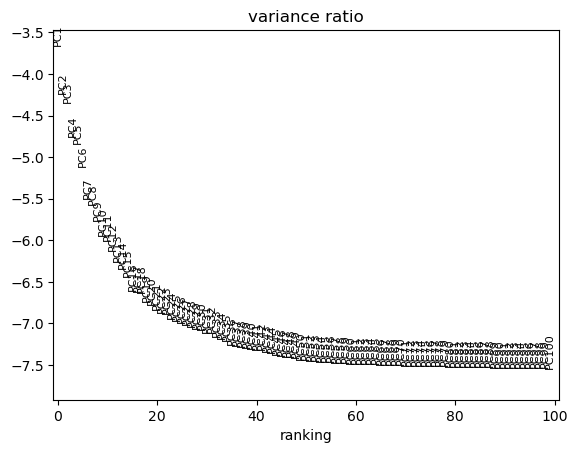

In [32]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

In [33]:
rsc.get.anndata_to_CPU(adata)

In [34]:
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

In [35]:
rsc.tl.umap(adata)

In [36]:
rsc.tl.louvain(adata, resolution=0.6)

In [37]:
rsc.tl.leiden(adata, resolution=0.6)

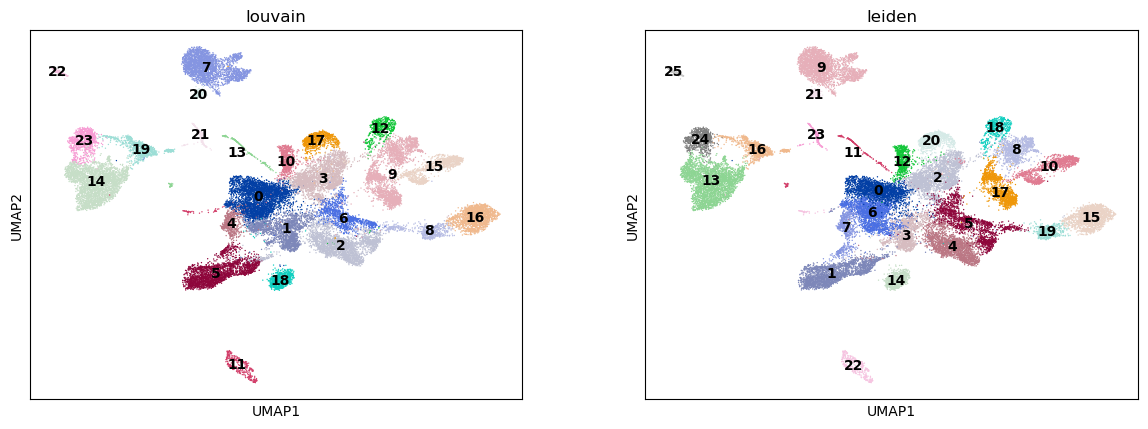

In [38]:
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

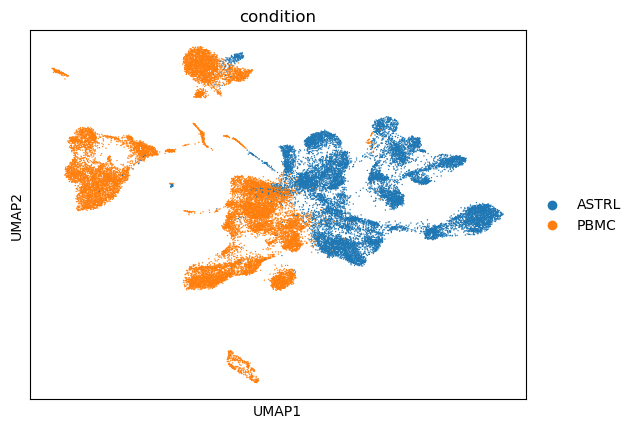

In [39]:
sc.pl.umap(adata, color=["condition"],ncols=1,)

In [40]:

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [42]:
rsc.pp.harmony_integrate(
    adata, key=["patient_id", "condition"],
    dtype=cp.float32)


In [43]:
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,use_rep="X_pca_harmony",key_added="harmony")
rsc.tl.umap(adata,neighbors_key="harmony",key_added="X_umap_harmony")
rsc.tl.louvain(adata, resolution=0.6,neighbors_key="harmony",key_added="louvain_harmony")
rsc.tl.leiden(adata, resolution=0.6,neighbors_key="harmony",key_added="leiden_harmony")

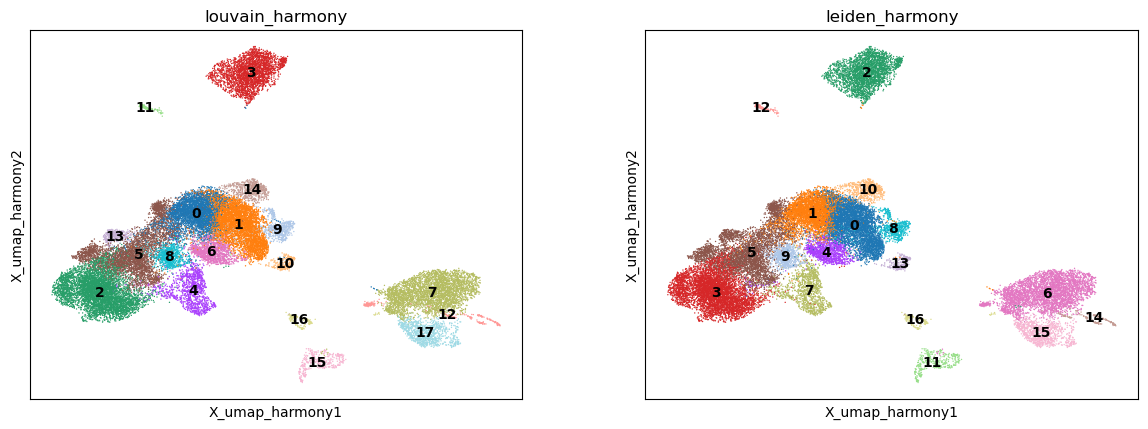

In [44]:
sc.pl.embedding(adata,basis="X_umap_harmony", color=["louvain_harmony", "leiden_harmony"], legend_loc="on data")

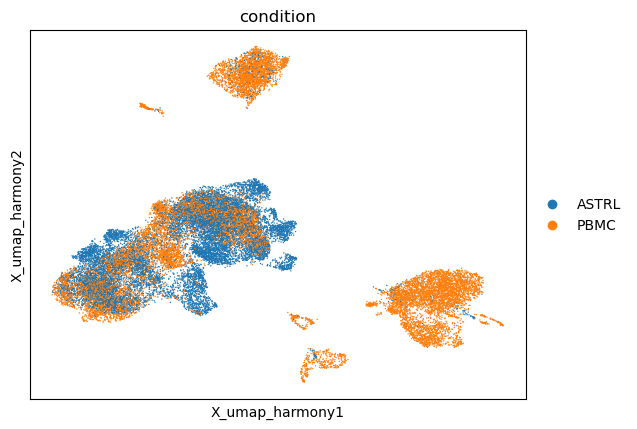

In [45]:
sc.pl.embedding(
    adata,basis="X_umap_harmony",
    color=["condition"], ncols=1)


In [64]:
adata = adata.raw.to_adata()

AttributeError: 'NoneType' object has no attribute 'to_adata'

In [63]:
adata

AnnData object with n_obs × n_vars = 30601 × 21156
    obs: 'sample', 'patient_id', 'condition', 'obs_index', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_HB', 'pct_counts_HB', 'outlier', 'soupX_contamination', 'louvain', 'leiden', 'louvain_harmony', 'leiden_harmony'
    var: 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'leiden', 'louvain_colors', 'leiden_colors', 'condition_colors', 'harmony', 'X_umap_harmony', 'louvain_harmony', 'leiden_harmony', 'louvain_harmony_colors', 'leiden_harmony_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony', 'X_umap_harmony'
    obsp: 'distances', 'connectivities', 'harmony_distances', 'harmony_connectivities'

In [65]:
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata_celltypist.X.toarray()

In [66]:
import celltypist
from celltypist import models

In [67]:
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)

2025-11-03 17:32:53 | [INFO] 📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
2025-11-03 17:32:54 | [INFO] 📚 Total models in list: 58
2025-11-03 17:32:54 | [INFO] 📂 Storing models in /home/ozkan.aydemir-umw/.celltypist/data/models
2025-11-03 17:32:54 | [INFO] 💾 Total models to download: 2
2025-11-03 17:32:54 | [INFO] 💾 Downloading model [1/2]: Immune_All_Low.pkl
2025-11-03 17:32:55 | [INFO] 💾 Downloading model [2/2]: Immune_All_High.pkl


In [68]:
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

In [70]:
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)
predictions_high_adata = predictions_high.to_adata()

2025-11-03 17:33:12 | [INFO] 🔬 Input data has 30601 cells and 21156 genes
2025-11-03 17:33:12 | [INFO] 🔗 Matching reference genes in the model
2025-11-03 17:33:14 | [INFO] 🧬 5801 features used for prediction
2025-11-03 17:33:14 | [INFO] ⚖️ Scaling input data
2025-11-03 17:33:17 | [INFO] 🖋️ Predicting labels
2025-11-03 17:33:17 | [INFO] ✅ Prediction done!
2025-11-03 17:33:17 | [INFO] 👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
2025-11-03 17:33:17 | [INFO] ⛓️ Over-clustering input data with resolution set to 15
2025-11-03 17:33:18 | [INFO] 🗳️ Majority voting the predictions
2025-11-03 17:33:18 | [INFO] ✅ Majority voting done!


In [71]:
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "conf_score"
]

In [72]:
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)
predictions_low_adata = predictions_low.to_adata()
adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "conf_score"
]

2025-11-03 17:33:28 | [INFO] 🔬 Input data has 30601 cells and 21156 genes
2025-11-03 17:33:28 | [INFO] 🔗 Matching reference genes in the model
2025-11-03 17:33:30 | [INFO] 🧬 5801 features used for prediction
2025-11-03 17:33:30 | [INFO] ⚖️ Scaling input data
2025-11-03 17:33:33 | [INFO] 🖋️ Predicting labels
2025-11-03 17:33:33 | [INFO] ✅ Prediction done!
2025-11-03 17:33:33 | [INFO] 👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
2025-11-03 17:33:33 | [INFO] ⛓️ Over-clustering input data with resolution set to 15
2025-11-03 17:33:34 | [INFO] 🗳️ Majority voting the predictions
2025-11-03 17:33:34 | [INFO] ✅ Majority voting done!


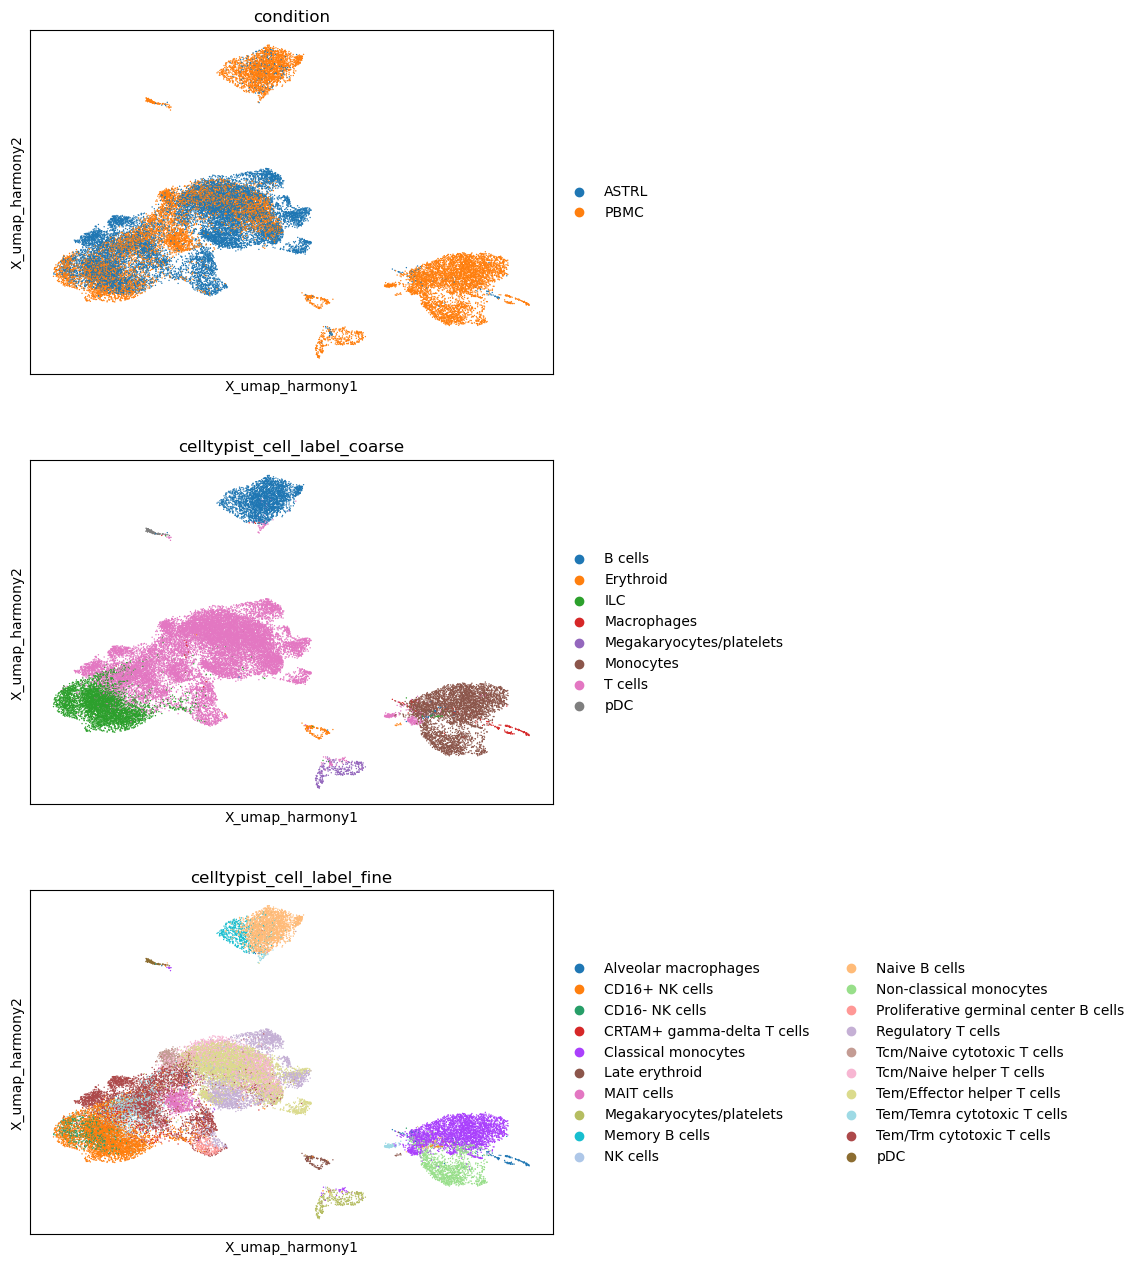

In [77]:
sc.pl.embedding(
    adata,basis="X_umap_harmony",
    color=[ "condition", "celltypist_cell_label_coarse",
            "celltypist_cell_label_fine"], ncols=1)


In [74]:
rsc.tl.tsne(adata, n_pcs=40, perplexity=30, early_exaggeration=12, learning_rate=200, use_rep="X_pca_harmony")


[2025-11-03 17:37:42.861] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


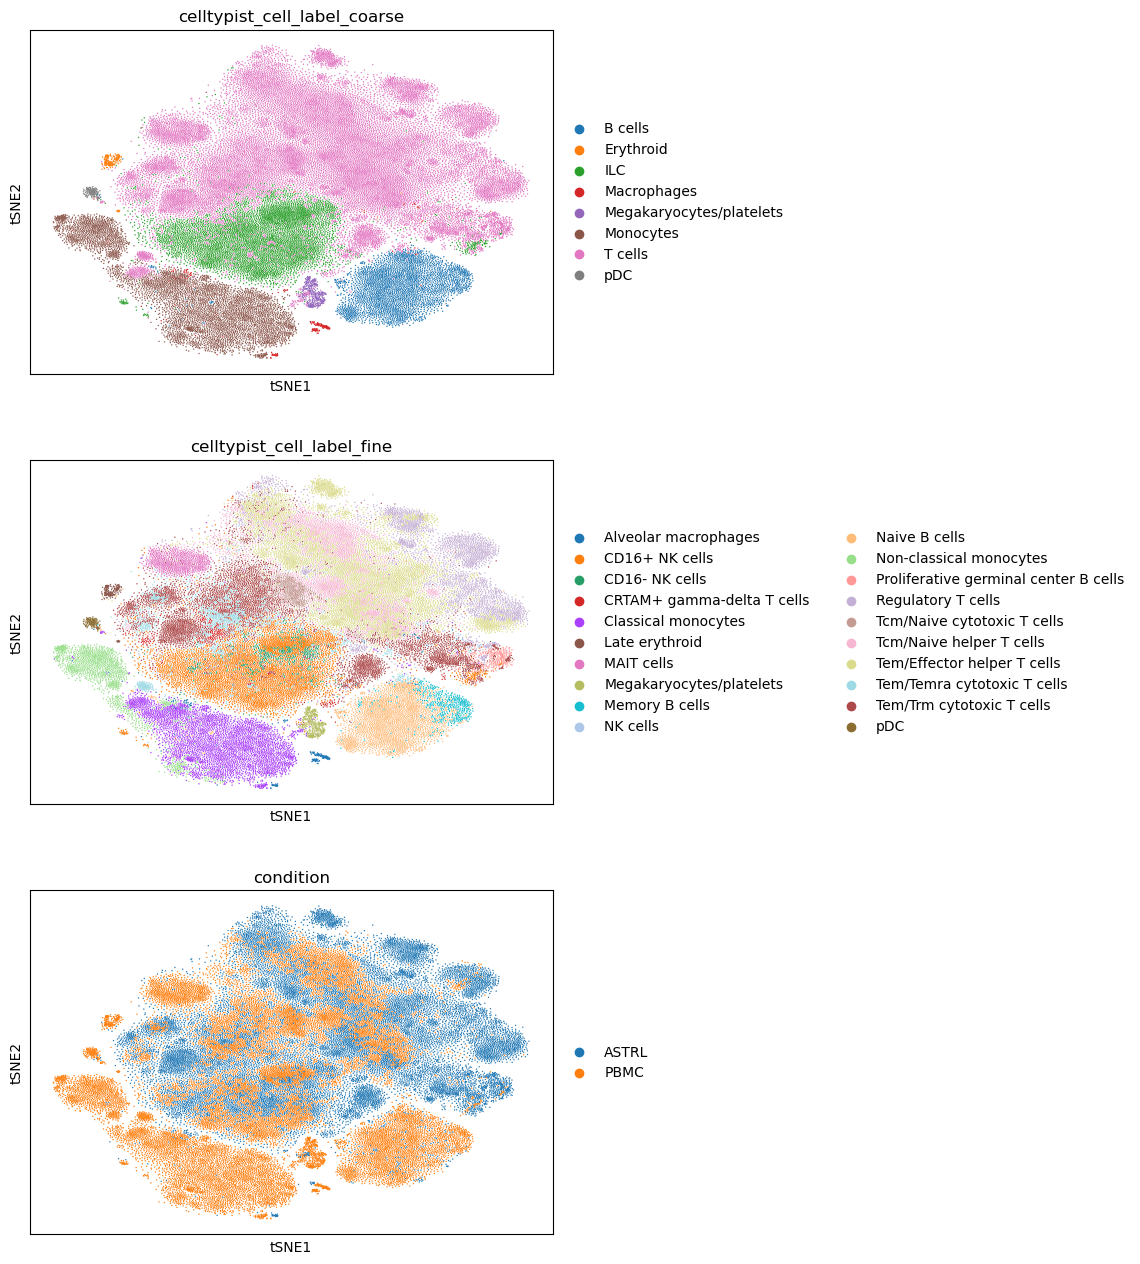

In [76]:
sc.pl.tsne(adata, color=[ "celltypist_cell_label_coarse",
            "celltypist_cell_label_fine", "condition"], ncols=1)

In [125]:
adata = sc.concat(adata_dict)

In [90]:
sc.pp.filter_genes(adata, min_cells=3)

In [91]:
adata_pb = adata[adata.obs["condition"] == "PBMC"].copy()

In [92]:
adata_as = adata[adata.obs["condition"] == "ASTRL"].copy()

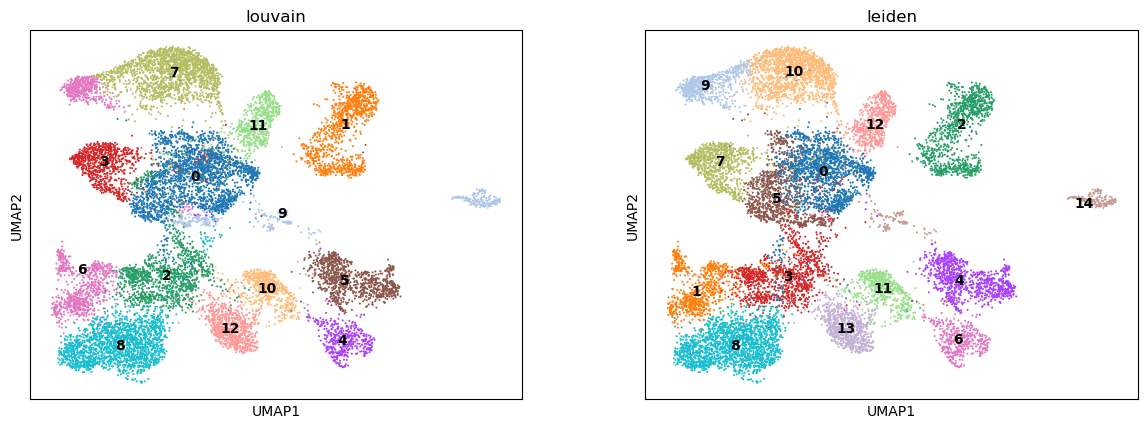

In [94]:
adata = adata_as
rsc.get.anndata_to_GPU(adata)
rsc.pp.normalize_total(adata, target_sum=1e4)
rsc.pp.log1p(adata)
rsc.pp.highly_variable_genes(
    adata, n_top_genes=5000, flavor="cell_ranger",
    batch_key="patient_id")
adata.raw = adata
rsc.pp.filter_highly_variable(adata)
rsc.pp.scale(adata, max_value=10)
rsc.tl.pca(adata, n_comps=100)
rsc.get.anndata_to_CPU(adata)
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
rsc.tl.umap(adata)
rsc.tl.louvain(adata, resolution=0.6)
rsc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

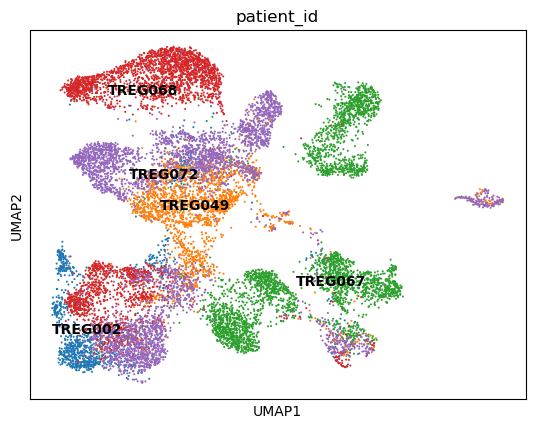

In [97]:
sc.pl.umap(adata, color=["patient_id"], legend_loc="on data")

In [96]:
rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

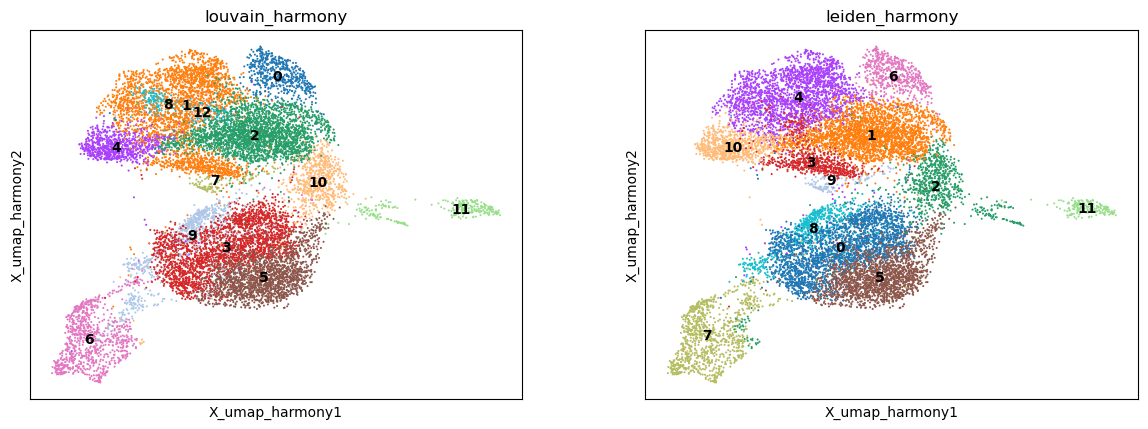

In [98]:
rsc.pp.harmony_integrate(
    adata, key=["patient_id"],
    dtype=cp.float32)

rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,use_rep="X_pca_harmony",key_added="harmony")
rsc.tl.umap(adata,neighbors_key="harmony",key_added="X_umap_harmony")
rsc.tl.louvain(adata, resolution=0.6,neighbors_key="harmony",key_added="louvain_harmony")
rsc.tl.leiden(adata, resolution=0.6,neighbors_key="harmony",key_added="leiden_harmony")
sc.pl.embedding(adata,basis="X_umap_harmony", color=["louvain_harmony", "leiden_harmony"], legend_loc="on data")

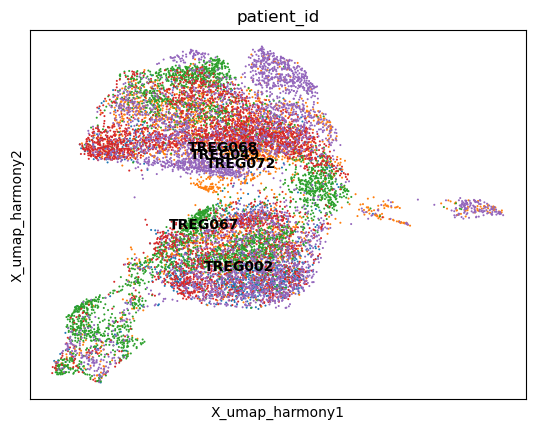

In [100]:
sc.pl.embedding(adata,basis="X_umap_harmony", color=["patient_id"],
                legend_loc="on data")

In [101]:
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 13831 × 21146
    obs: 'sample', 'patient_id', 'condition', 'obs_index', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_HB', 'pct_counts_HB', 'outlier', 'soupX_contamination', 'louvain', 'leiden', 'louvain_harmony', 'leiden_harmony'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'leiden', 'louvain_colors', 'leiden_colors', 'condition_colors', 'patient_id_colors', 'harmony', 'X_umap_harmony', 'louvain_harmony', 'leiden_harmony', 'louvain_harmony_colors', 'leiden_harmony_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony', 'X_umap_harmony'
    obsp: 'distances', 'connectivities', 'harmony_distances', 'harmony_connectivities'

In [102]:
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata_celltypist.X.toarray()
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)
predictions_high_adata = predictions_high.to_adata()
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "conf_score"
]
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)
predictions_low_adata = predictions_low.to_adata()
adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "conf_score"
]

2025-11-03 22:12:33 | [INFO] 🔬 Input data has 13831 cells and 21146 genes
2025-11-03 22:12:33 | [INFO] 🔗 Matching reference genes in the model
2025-11-03 22:12:35 | [INFO] 🧬 5801 features used for prediction
2025-11-03 22:12:35 | [INFO] ⚖️ Scaling input data
2025-11-03 22:12:36 | [INFO] 🖋️ Predicting labels
2025-11-03 22:12:36 | [INFO] ✅ Prediction done!
2025-11-03 22:12:36 | [INFO] 👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
2025-11-03 22:12:36 | [INFO] ⛓️ Over-clustering input data with resolution set to 10
2025-11-03 22:12:37 | [INFO] 🗳️ Majority voting the predictions
2025-11-03 22:12:37 | [INFO] ✅ Majority voting done!
2025-11-03 22:12:37 | [INFO] 🔬 Input data has 13831 cells and 21146 genes
2025-11-03 22:12:37 | [INFO] 🔗 Matching reference genes in the model
2025-11-03 22:12:38 | [INFO] 🧬 5801 features used for prediction
2025-11-03 22:12:38 | [INFO] ⚖️ Scaling input data
2025-11-03 22:12:39 | [INFO] 🖋️ Predicting labels
2025-1

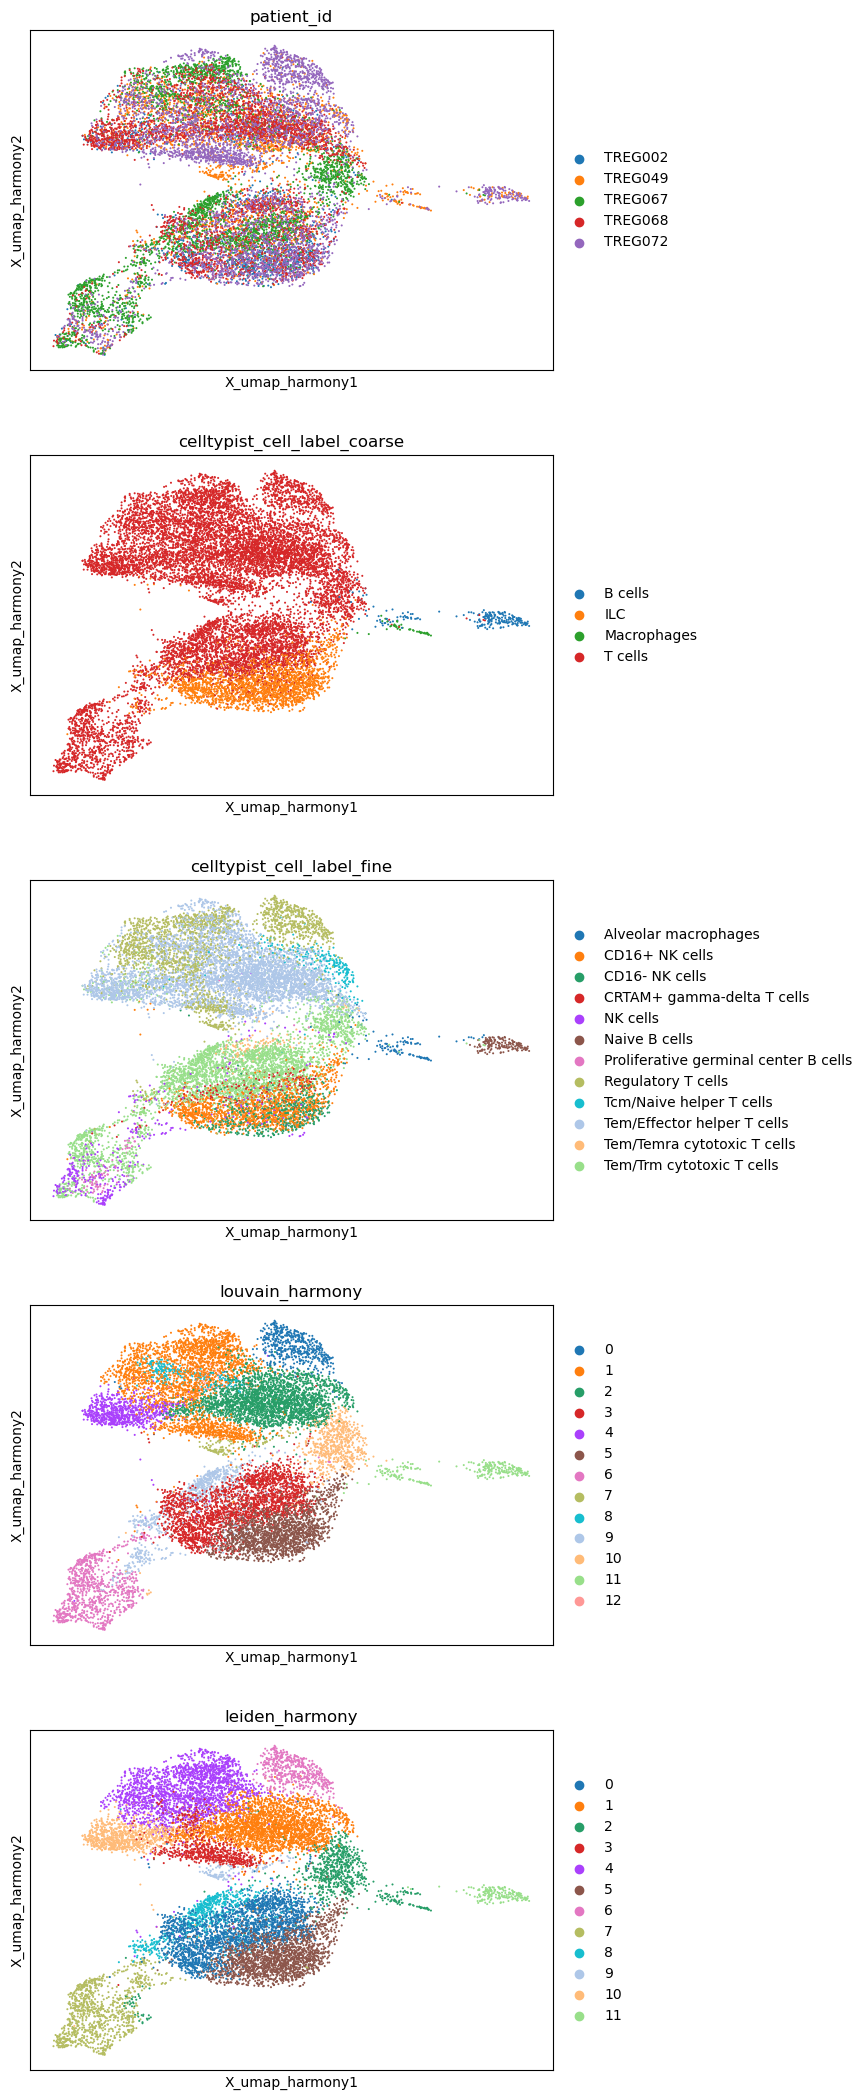

In [104]:
sc.pl.embedding(
    adata,basis="X_umap_harmony",
    color=[ "patient_id", "celltypist_cell_label_coarse",
            "celltypist_cell_label_fine",
          "louvain_harmony", "leiden_harmony"], ncols=1)


In [109]:
rsc.tl.tsne(adata, n_pcs=40, perplexity=10, early_exaggeration=12, learning_rate=200, use_rep="X_pca_harmony")

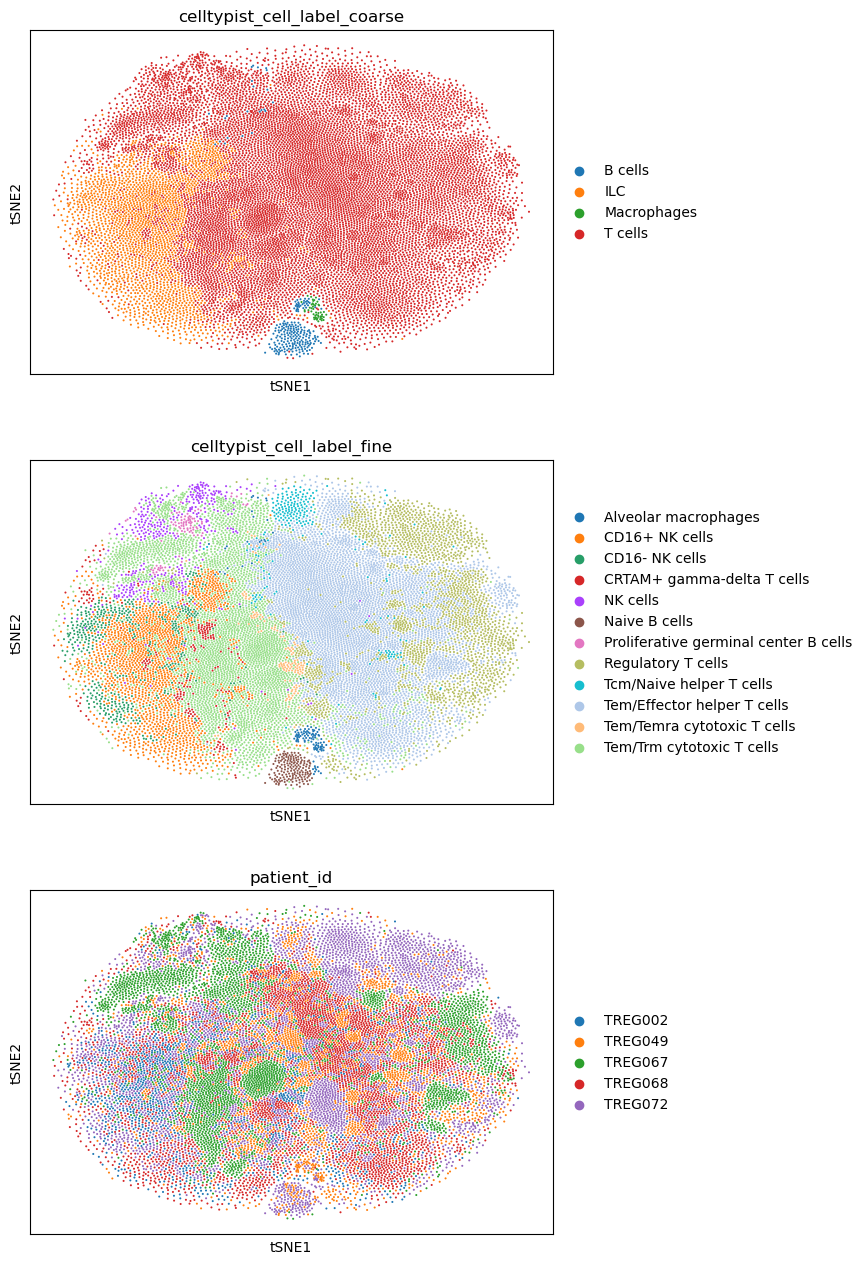

In [110]:
sc.pl.tsne(adata, color=[ "celltypist_cell_label_coarse",
            "celltypist_cell_label_fine", "patient_id"], ncols=1)

In [111]:
adata_as = adata.copy()

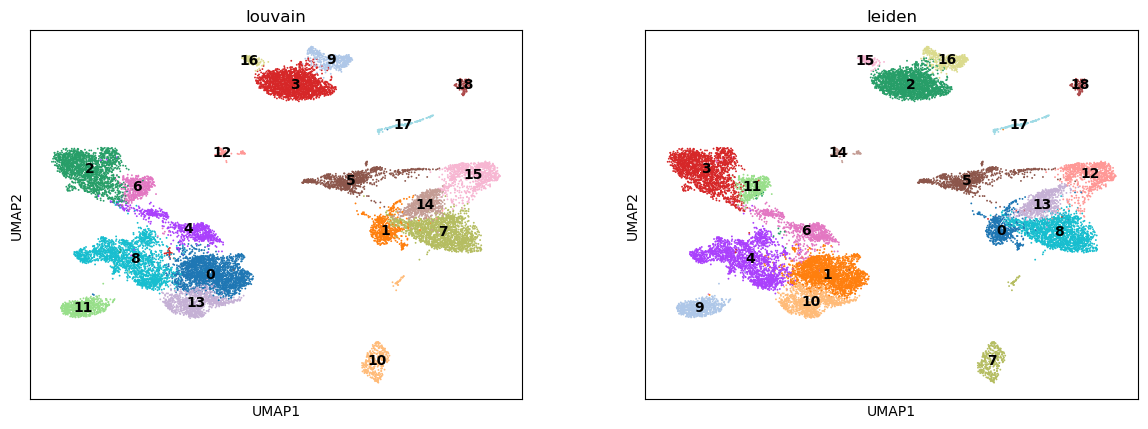

In [112]:
adata = adata_pb
rsc.get.anndata_to_GPU(adata)
rsc.pp.normalize_total(adata, target_sum=1e4)
rsc.pp.log1p(adata)
rsc.pp.highly_variable_genes(
    adata, n_top_genes=5000, flavor="cell_ranger",
    batch_key="patient_id")
adata.raw = adata
rsc.pp.filter_highly_variable(adata)
rsc.pp.scale(adata, max_value=10)
rsc.tl.pca(adata, n_comps=100)
rsc.get.anndata_to_CPU(adata)
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
rsc.tl.umap(adata)
rsc.tl.louvain(adata, resolution=0.6)
rsc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

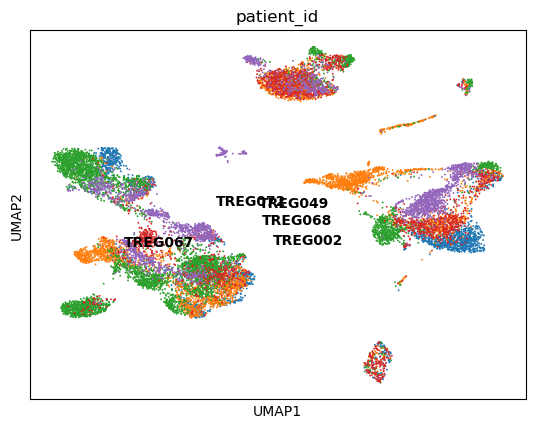

In [113]:
sc.pl.umap(adata, color=["patient_id"], legend_loc="on data")

In [133]:
rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

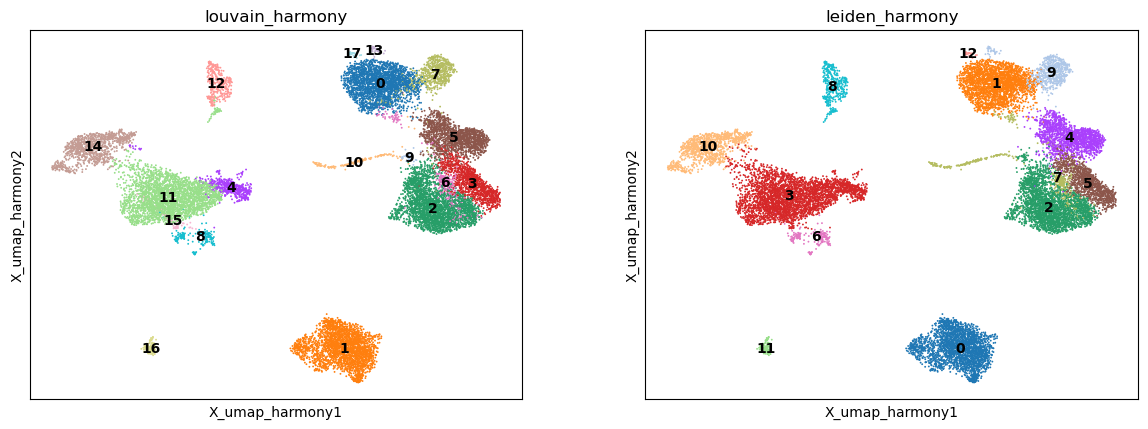

In [115]:
rsc.pp.harmony_integrate(
    adata, key=["patient_id"],
    dtype=cp.float32)

rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,use_rep="X_pca_harmony",key_added="harmony")
rsc.tl.umap(adata,neighbors_key="harmony",key_added="X_umap_harmony")
rsc.tl.louvain(adata, resolution=0.6,neighbors_key="harmony",key_added="louvain_harmony")
rsc.tl.leiden(adata, resolution=0.6,neighbors_key="harmony",key_added="leiden_harmony")
sc.pl.embedding(adata,basis="X_umap_harmony", color=["louvain_harmony", "leiden_harmony"], legend_loc="on data")

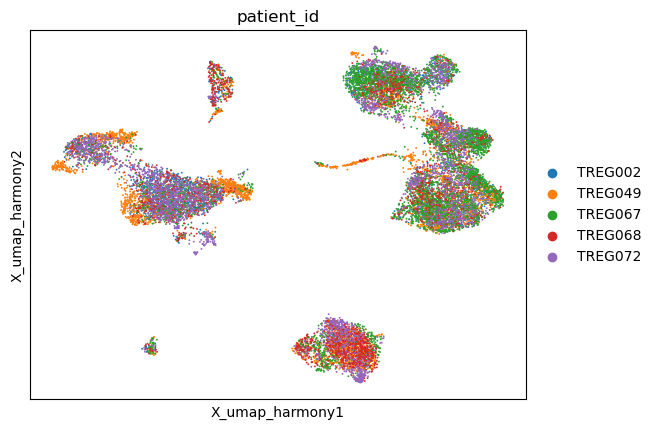

In [117]:
sc.pl.embedding(adata,basis="X_umap_harmony", color=["patient_id"],
                )

In [118]:
adata = adata.raw.to_adata()
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata_celltypist.X.toarray()
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)
predictions_high_adata = predictions_high.to_adata()
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "conf_score"
]
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)
predictions_low_adata = predictions_low.to_adata()
adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "conf_score"
]

2025-11-03 22:32:01 | [INFO] 🔬 Input data has 16770 cells and 21146 genes
2025-11-03 22:32:01 | [INFO] 🔗 Matching reference genes in the model
2025-11-03 22:32:02 | [INFO] 🧬 5801 features used for prediction
2025-11-03 22:32:02 | [INFO] ⚖️ Scaling input data
2025-11-03 22:32:03 | [INFO] 🖋️ Predicting labels
2025-11-03 22:32:04 | [INFO] ✅ Prediction done!
2025-11-03 22:32:04 | [INFO] 👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
2025-11-03 22:32:04 | [INFO] ⛓️ Over-clustering input data with resolution set to 10
2025-11-03 22:32:04 | [INFO] 🗳️ Majority voting the predictions
2025-11-03 22:32:04 | [INFO] ✅ Majority voting done!
2025-11-03 22:32:04 | [INFO] 🔬 Input data has 16770 cells and 21146 genes
2025-11-03 22:32:04 | [INFO] 🔗 Matching reference genes in the model
2025-11-03 22:32:06 | [INFO] 🧬 5801 features used for prediction
2025-11-03 22:32:06 | [INFO] ⚖️ Scaling input data
2025-11-03 22:32:07 | [INFO] 🖋️ Predicting labels
2025-1

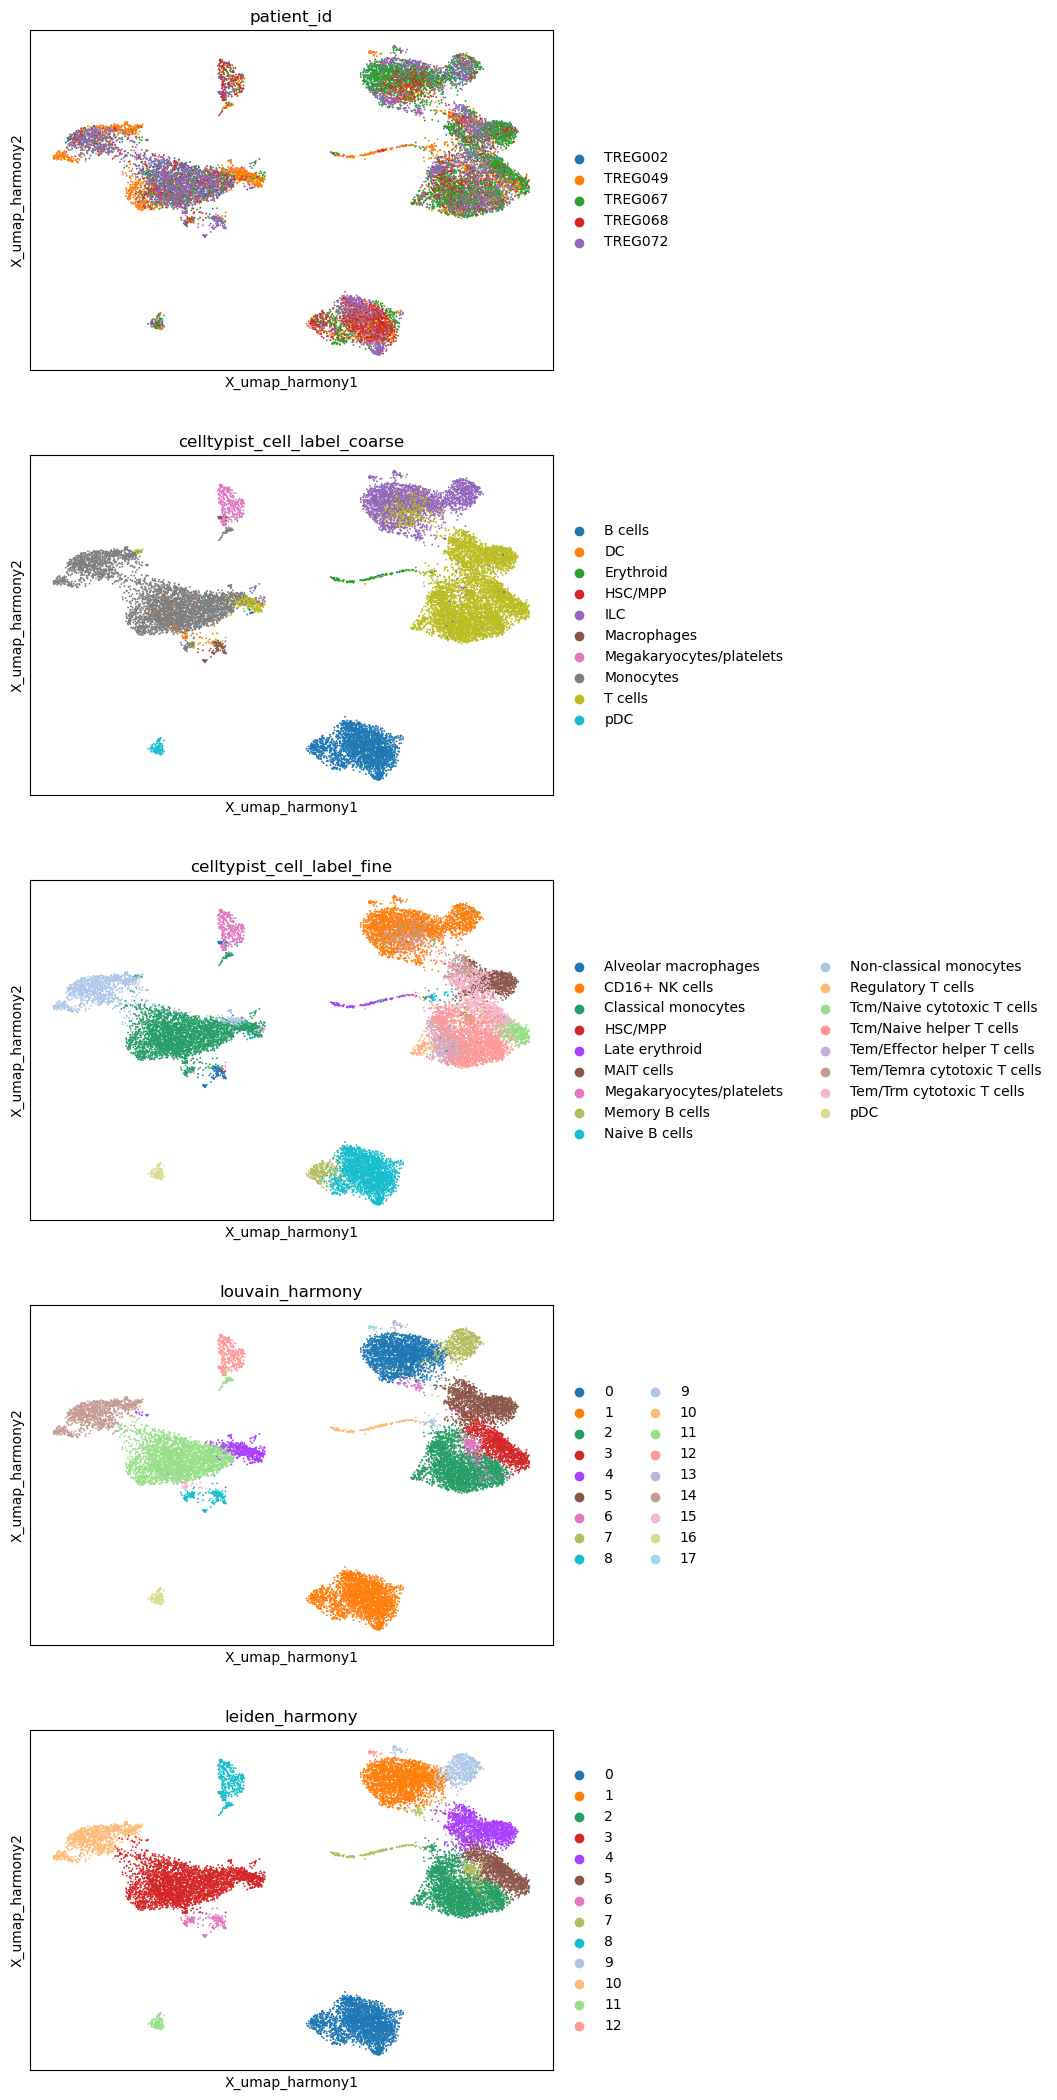

In [119]:
sc.pl.embedding(
    adata,basis="X_umap_harmony",
    color=[ "patient_id", "celltypist_cell_label_coarse",
            "celltypist_cell_label_fine",
          "louvain_harmony", "leiden_harmony"], ncols=1)


In [120]:
rsc.tl.tsne(adata, n_pcs=40, perplexity=10, early_exaggeration=12, learning_rate=200, use_rep="X_pca_harmony")

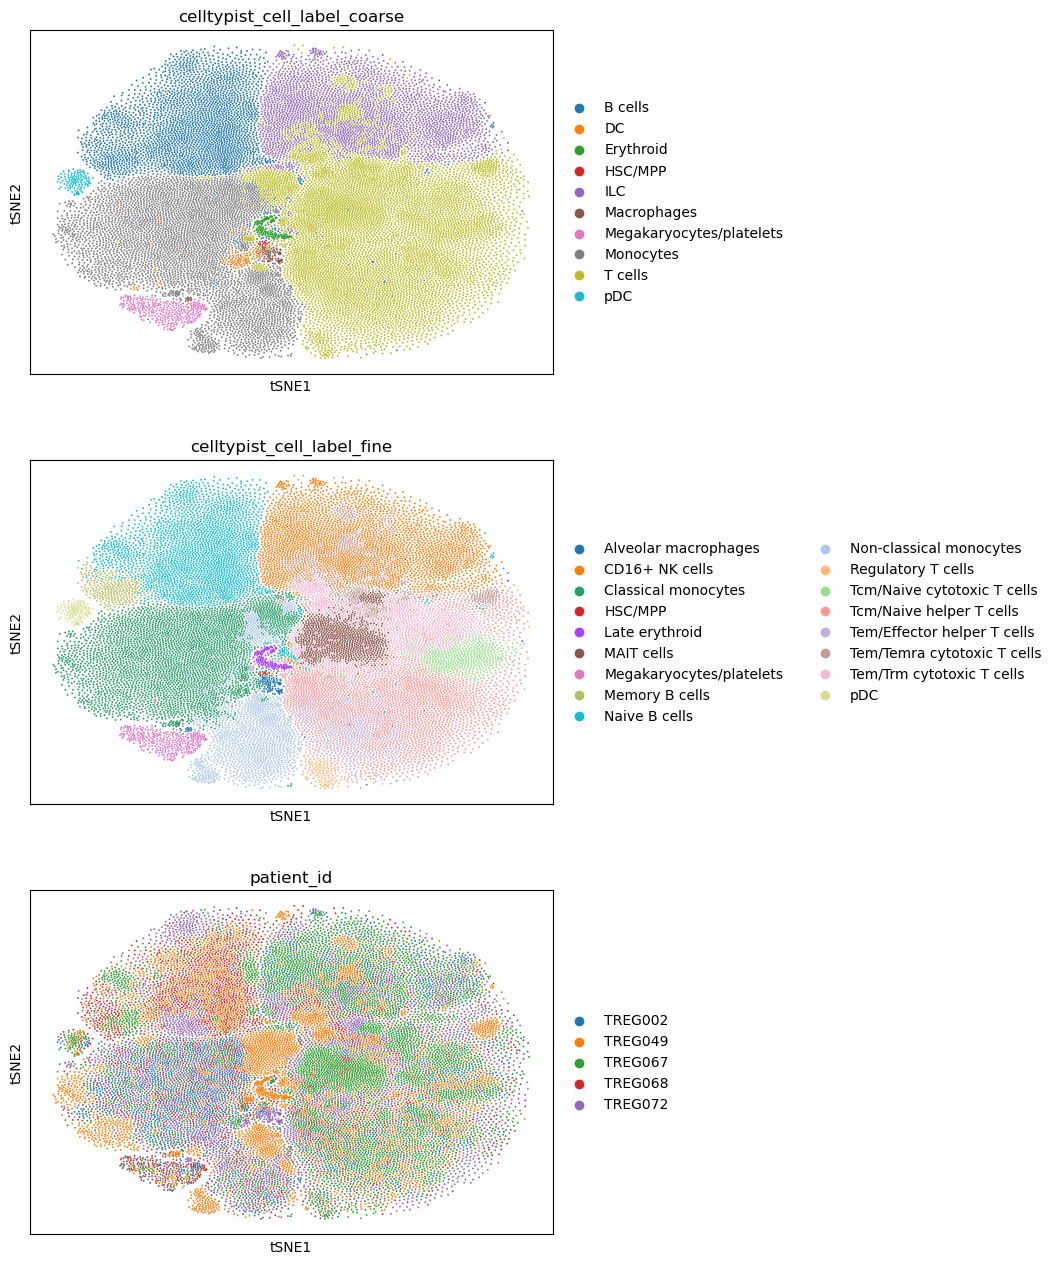

In [121]:
sc.pl.tsne(adata, color=[ "celltypist_cell_label_coarse",
            "celltypist_cell_label_fine", "patient_id"], ncols=1)

In [122]:
adata_pb = adata.copy()

In [123]:
adata_pb

AnnData object with n_obs × n_vars = 16770 × 21146
    obs: 'sample', 'patient_id', 'condition', 'obs_index', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_HB', 'pct_counts_HB', 'outlier', 'soupX_contamination', 'louvain', 'leiden', 'louvain_harmony', 'leiden_harmony', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'leiden', 'louvain_colors', 'leiden_colors', 'patient_id_colors', 'harmony', 'X_umap_harmony', 'louvain_harmony', 'leiden_harmony', 'louvain_harmony_colors', 'leiden_harmony_colors', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_fine_colors', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony', 'X_umap_

In [124]:
adata_as

AnnData object with n_obs × n_vars = 13831 × 21146
    obs: 'sample', 'patient_id', 'condition', 'obs_index', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_HB', 'pct_counts_HB', 'outlier', 'soupX_contamination', 'louvain', 'leiden', 'louvain_harmony', 'leiden_harmony', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'leiden', 'louvain_colors', 'leiden_colors', 'condition_colors', 'patient_id_colors', 'harmony', 'X_umap_harmony', 'louvain_harmony', 'leiden_harmony', 'louvain_harmony_colors', 'leiden_harmony_colors', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_fine_colors', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_pc

In [183]:
rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

RuntimeError: CUDA error at: /tmp/conda-bld-output/bld/rattler-build_librmm/work/cpp/src/cuda_device.cpp:46: cudaErrorIllegalAddress an illegal memory access was encountered

In [179]:
rsc.get.anndata_to_CPU(
    adata)

In [180]:
adata

AnnData object with n_obs × n_vars = 13831 × 21146
    obs: 'sample', 'patient_id', 'condition', 'obs_index', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_HB', 'pct_counts_HB', 'outlier', 'soupX_contamination'
    var: 'n_cells'
    layers: 'counts', 'soupX_counts'

In [182]:
adata = sc.concat(adata_dict)
sc.pp.filter_genes(adata, min_cells=3)
adata_pb = adata[adata.obs["condition"] == "PBMC"].copy()
adata_as = adata[adata.obs["condition"] == "ASTRL"].copy()

adata = adata_as
rsc.get.anndata_to_GPU(
    adata)

MemoryError: std::bad_alloc: CUDA error (failed to allocate 157799328 bytes) at: /home/ozkan.aydemir-umw/miniconda3/envs/rapids_singlecell/include/rmm/mr/device/cuda_memory_resource.hpp

In [172]:



rsc.pp.normalize_total(adata, target_sum=1e4)
rsc.pp.log1p(adata)
rsc.pp.highly_variable_genes(
    adata, n_top_genes=4000, flavor="cell_ranger",
    batch_key="patient_id")
adata.raw = adata
rsc.pp.filter_highly_variable(adata)
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])
rsc.pp.scale(adata, max_value=10)
rsc.tl.pca(adata, n_comps=100)
rsc.get.anndata_to_CPU(adata)
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
rsc.tl.umap(adata)
rsc.tl.louvain(adata, resolution=0.6)
rsc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

MemoryError: std::bad_alloc: CUDA error (failed to allocate 13840 bytes) at: /home/ozkan.aydemir-umw/miniconda3/envs/rapids_singlecell/include/rmm/mr/device/managed_memory_resource.hpp

In [ ]:
sc.pl.umap(adata, color=["patient_id"], legend_loc="on data")

In [ ]:
rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

rsc.pp.harmony_integrate(
    adata, key=["patient_id"],
    dtype=cp.float32)

rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,use_rep="X_pca_harmony",key_added="harmony")
rsc.tl.umap(adata,neighbors_key="harmony",key_added="X_umap_harmony")
rsc.tl.louvain(adata, resolution=0.6,neighbors_key="harmony",key_added="louvain_harmony")
rsc.tl.leiden(adata, resolution=0.6,neighbors_key="harmony",key_added="leiden_harmony")
sc.pl.embedding(adata,basis="X_umap_harmony", color=["louvain_harmony", "leiden_harmony"], legend_loc="on data")

In [ ]:
sc.pl.embedding(adata,basis="X_umap_harmony", color=["patient_id"],
                legend_loc="on data")

2025-11-03 23:39:07 | [INFO] 🔬 Input data has 13831 cells and 21146 genes
2025-11-03 23:39:07 | [INFO] 🔗 Matching reference genes in the model
2025-11-03 23:39:08 | [INFO] 🧬 5801 features used for prediction
2025-11-03 23:39:08 | [INFO] ⚖️ Scaling input data
2025-11-03 23:39:10 | [INFO] 🖋️ Predicting labels
2025-11-03 23:39:10 | [INFO] ✅ Prediction done!
2025-11-03 23:39:10 | [INFO] 👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
2025-11-03 23:39:10 | [INFO] ⛓️ Over-clustering input data with resolution set to 10
2025-11-03 23:39:10 | [INFO] 🗳️ Majority voting the predictions
2025-11-03 23:39:10 | [INFO] ✅ Majority voting done!
2025-11-03 23:39:10 | [INFO] 🔬 Input data has 13831 cells and 21146 genes
2025-11-03 23:39:10 | [INFO] 🔗 Matching reference genes in the model
2025-11-03 23:39:12 | [INFO] 🧬 5801 features used for prediction
2025-11-03 23:39:12 | [INFO] ⚖️ Scaling input data
2025-11-03 23:39:13 | [INFO] 🖋️ Predicting labels
2025-1

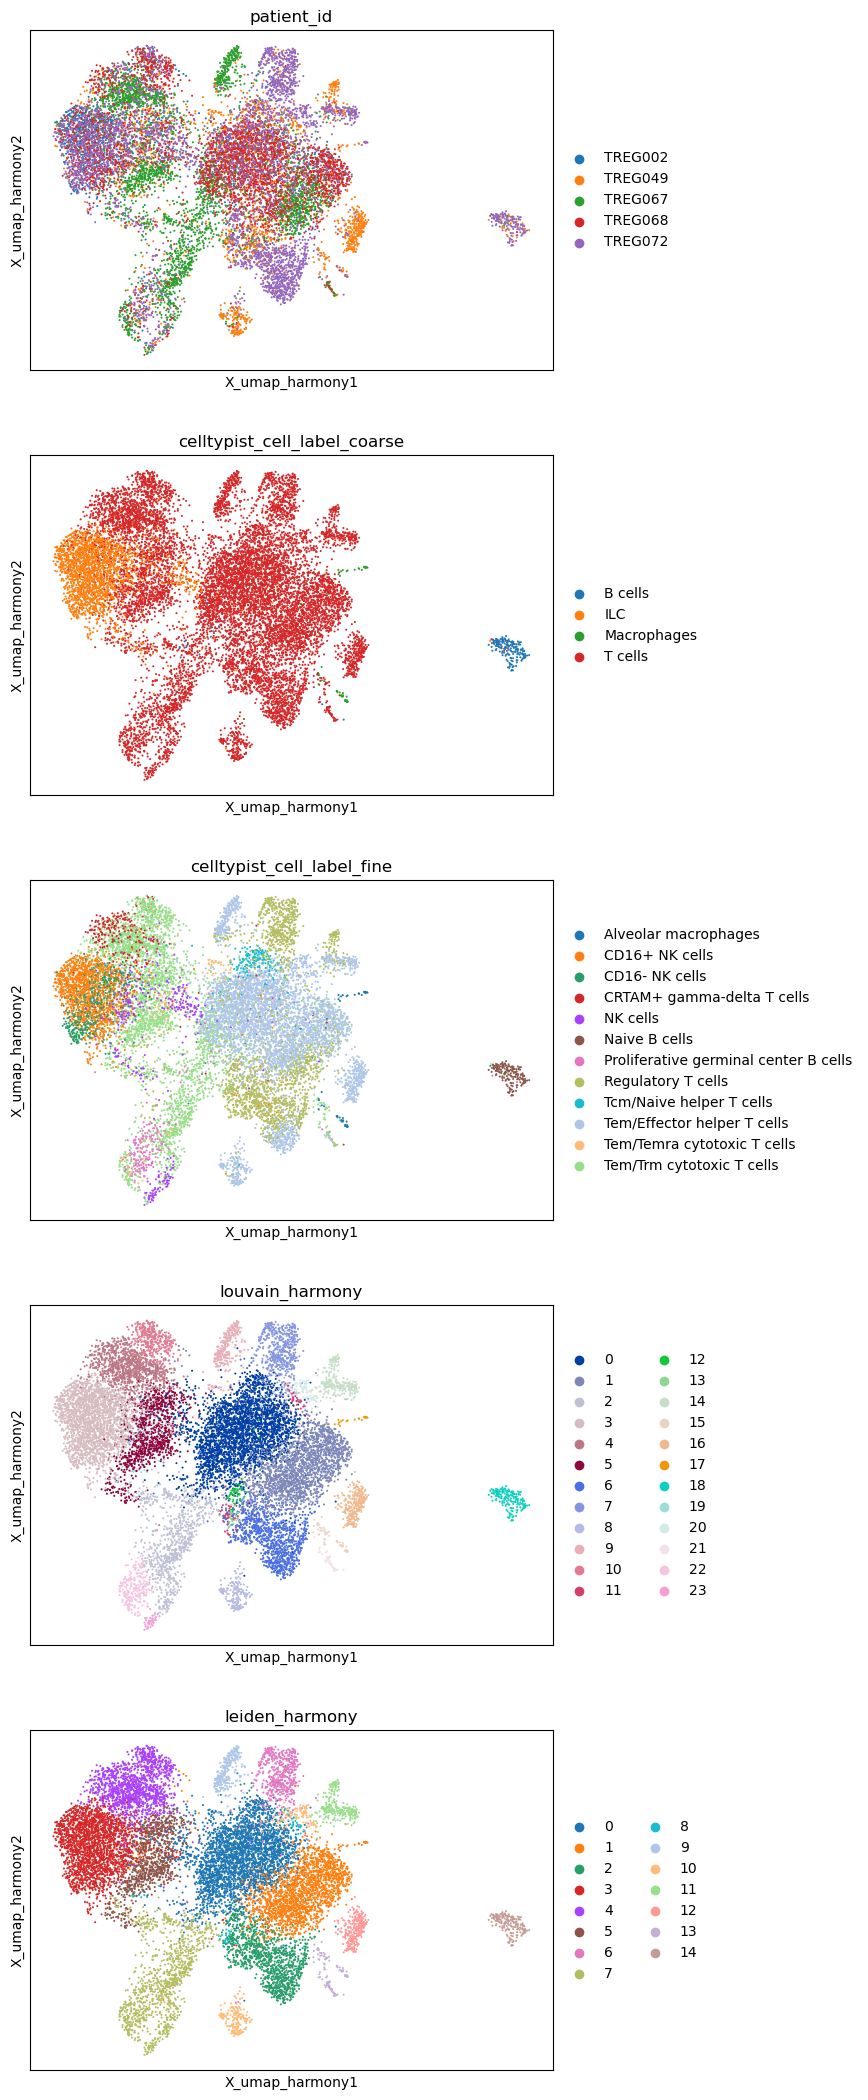

In [161]:
adata = adata.raw.to_adata()
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata_celltypist.X.toarray()
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)
predictions_high_adata = predictions_high.to_adata()
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "conf_score"
]
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)
predictions_low_adata = predictions_low.to_adata()
adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "conf_score"
]
sc.pl.embedding(
    adata,basis="X_umap_harmony",
    color=[ "patient_id", "celltypist_cell_label_coarse",
            "celltypist_cell_label_fine",
          "louvain_harmony", "leiden_harmony"], ncols=1)
